In [22]:
import os

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
# from LinearRL import LinearRL
from utils import create_transition_matrix_mapping, get_transition_matrix, make_plots, record_trajectory, test_agent

In [2]:
class LinearRL:
    def __init__(self, env_name, alpha=0.1, gamma=0.904, _lambda=1.0, epsilon=0.4, num_steps=25000, policy="random"):
        self.env = gym.make(env_name)
        self.start_loc = self.env.unwrapped.start_loc
        self.target_loc = self.env.unwrapped.target_loc
        self.maze = self.env.unwrapped.maze
        self.size = self.maze.size
        self.height, self.width = self.maze.shape
        self.target_locs = [self.target_loc]
        self.mapping = create_transition_matrix_mapping(self.maze)
        self.T, self.barriers = get_transition_matrix(self.env, self.size, self.mapping)
        

        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]
        # self.P = self.T[:, self.terminals]
        # Calculate reward
        self.r = np.full(len(self.T), -0.1)     # our reward at each non-terminal state to be -1
        self.r[self.terminals] = 1           # reward at terminal state is 0
        self.expr_t = np.exp(self.r[self.terminals] / _lambda)      # exp(r) = exp(-c) at terminal state
        self.expr_nt = np.exp(-0.1/_lambda)     # exp(r) = exp(-c) at non-terminal states

        # Params
        self.alpha = alpha
        self.gamma = self.expr_nt
        self._lambda = _lambda
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.policy = policy

        # Model
        self.DR = self.get_DR()
        self.Z = np.full(self.size, 0.01)

        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)

    def get_DR(self):
        if self.policy == "random":
            DR = np.eye(self.size)
        
        elif self.policy == "softmax":
            DR = np.full((self.size, self.size), 0.01)
            DR[:, self.barriers] = 0
            DR[self.barriers, :] = 0
            np.fill_diagonal(DR, 1)

        return DR

    def update_V(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)
    
    def importance_sampling(self, state, s_prob):
        successor_states = self.env.unwrapped.get_successor_states(state)
        p = 1/len(successor_states)
        w = p/s_prob
                
        return w

    def select_action(self, state, beta=5, target_loc=None):
        if self.policy == "random":
            return self.env.unwrapped.random_action()
        
        elif self.policy == "softmax":
            successor_states = self.env.unwrapped.get_successor_states(state)      # succesor_states = [(state, terminated), ...]
            action_probs = np.full(self.env.action_space.n, 0.0)

            v_sum = sum(
                        np.exp((np.log(self.Z[self.mapping[(s[0][0],s[0][1])]] + 1e-20)) / beta) for s in successor_states
                        )

            # if we don't have enough info, random action
            if v_sum == 0:
                return self.env.unwrapped.random_action() 

            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction
                
                action_probs[action] = np.exp((np.log(self.Z[self.mapping[(new_state[0], new_state[1])]] + 1e-20)) / beta ) / v_sum

            action = np.random.choice(self.env.action_space.n, p=action_probs)
            s_prob = action_probs[action]

            return action, s_prob
    
        elif self.policy == "egreedy":
            if np.random.uniform(low=0, high=1) < self.epsilon:
                return self.env.unwrapped.random_action()
            else:
                action_values = np.full(self.env.action_space.n, -np.inf)
                for action in self.env.unwrapped.get_available_actions(state):
                    direction = self.env.unwrapped._action_to_direction[action]
                    new_state = state + direction

                    if self.maze[new_state[0], new_state[1]] == "1":
                        continue

                    action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

                return np.argmax(action_values)
            
        elif self.policy == "test":
            action_values = np.full(self.env.action_space.n, -np.inf)
            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction

                # Need this to make it work for now
                if np.array_equal(new_state, target_loc):
                    return action

                if self.maze[new_state[0], new_state[1]] == "1":
                    continue
                action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

            return np.nanargmax(action_values)

    def get_D_inv(self):
        # New way of doing it
        I = np.eye(self.size)
        D_inv = np.linalg.inv(I-self.gamma*self.T)

        return D_inv

    def learn(self):
        """
        Agent randomly explores the maze and and updates its DR as it goes
        """
        print(f"Decision Policy: {self.policy}")
        self.env.reset()

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Current state
            state = self.env.unwrapped.agent_loc
            state_idx = self.mapping[(state[0], state[1])]

            # Choose action
            if self.policy == "softmax":
                action, s_prob = self.select_action(state, self.policy)
            else:
                action = self.select_action(state, self.policy)

            # Take action
            obs, _, done, _, _ = self.env.step(action)

            # Unpack observation to get new state
            next_state = obs["agent"]
            next_state_idx = self.mapping[(next_state[0], next_state[1])]

            # Importance sampling
            if self.policy == "softmax":
                w = self.importance_sampling(state, s_prob)
                w = 1 if np.isnan(w) or w == 0 else w
            else:
                w = 1
            
            ## Update default representation
            TDE =  self.one_hot[state_idx] + self.gamma * self.DR[next_state_idx]
            self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * TDE * w

            ## Update Z-Values
            self.Z = self.DR[:,~self.terminals] @ self.P @ self.expr_t

            # Update state
            if done:
                self.env.reset()
                continue
            state = next_state
            
        
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)

In [3]:
agent = LinearRL(env_name="tolman-10x10-latent", _lambda=1.0, alpha=0.01, num_steps=400000, policy="random")

In [4]:
agent.maze

array([['1', '0', '1', '1', '0', '1', '1', '0', '0', '0'],
       ['0', '0', '0', '0', '0', '0', '1', '0', '0', 'G'],
       ['0', '0', '0', '0', '0', '0', '1', '0', '1', '1'],
       ['1', '0', '1', '1', '0', '1', '1', '0', '1', '1'],
       ['1', '0', '1', '1', '0', '0', '0', '0', '1', '1'],
       ['1', '0', '1', '0', '0', '0', '0', '0', '1', '1'],
       ['1', '0', '1', '0', '0', '1', '1', '0', '1', '1'],
       ['S', '0', '1', '0', '0', '1', '0', '0', '1', '1'],
       ['0', '0', '1', '1', '0', '1', '0', '0', '0', '0'],
       ['1', '0', '1', '1', '0', '1', '1', '0', '0', '0']], dtype='<U21')

In [5]:
# Run learning on non-blocked detour environment
agent.learn()

Decision Policy: random


/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_9413/2454964959.py:178: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [6]:
agent.V.reshape((agent.height, agent.width))

array([[  -inf,  -8.23,   -inf,   -inf,  -6.76,   -inf,   -inf,  -0.09,
          0.17,   0.59],
       [ -8.3 ,  -8.06,  -7.49,  -6.99,  -6.65,  -6.58,   -inf,  -0.14,
          0.4 ,   1.  ],
       [ -8.33,  -8.01,  -7.33,  -6.72,  -5.98,  -6.35,   -inf,  -0.62,
          -inf,   -inf],
       [  -inf,  -8.66,   -inf,   -inf,  -5.03,   -inf,   -inf,  -1.23,
          -inf,   -inf],
       [  -inf,  -9.16,   -inf,   -inf,  -4.42,  -3.66,  -2.89,  -2.15,
          -inf,   -inf],
       [  -inf,  -9.64,   -inf,  -4.96,  -4.56,  -3.8 ,  -3.27,  -2.9 ,
          -inf,   -inf],
       [  -inf, -10.21,   -inf,  -5.34,  -5.15,   -inf,   -inf,  -3.39,
          -inf,   -inf],
       [-11.17, -10.78,   -inf,  -5.58,  -5.61,   -inf,  -4.65,  -4.19,
          -inf,   -inf],
       [-11.34, -11.26,   -inf,   -inf,  -5.99,   -inf,  -5.01,  -5.06,
         -5.65,  -6.08],
       [  -inf, -11.41,   -inf,   -inf,  -6.18,   -inf,   -inf,  -5.56,
         -5.91,  -6.13]])

In [7]:
# D_inv = agent.get_D_inv()
# agent.DR = D_inv
# agent.update_V()
# agent.V.reshape((agent.height, agent.width))

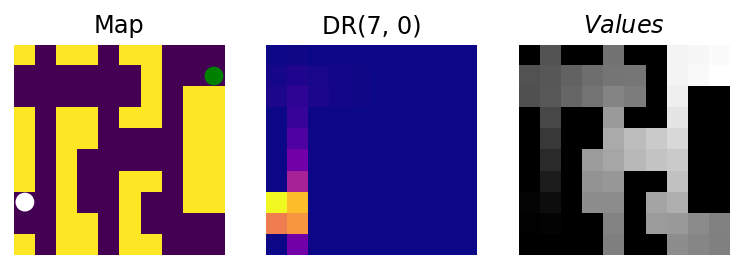

In [8]:
make_plots(agent)

In [9]:
print(f"Start location: {agent.start_loc}, Target location: {agent.target_loc}")
traj_old_goal = test_agent(agent)

Start location: [7 0], Target location: [1 9]
Starting in state: [7 0]
Took action: 1 and arrived in state: [7 1]
Took action: 2 and arrived in state: [6 1]
Took action: 2 and arrived in state: [5 1]
Took action: 2 and arrived in state: [4 1]
Took action: 2 and arrived in state: [3 1]
Took action: 2 and arrived in state: [2 1]
Took action: 1 and arrived in state: [2 2]
Took action: 1 and arrived in state: [2 3]
Took action: 1 and arrived in state: [2 4]
Took action: 0 and arrived in state: [3 4]
Took action: 0 and arrived in state: [4 4]
Took action: 1 and arrived in state: [4 5]
Took action: 1 and arrived in state: [4 6]
Took action: 1 and arrived in state: [4 7]
Took action: 2 and arrived in state: [3 7]
Took action: 2 and arrived in state: [2 7]
Took action: 2 and arrived in state: [1 7]
Took action: 1 and arrived in state: [1 8]
Took action: 1 and arrived in state: [1 9]
Took 19 steps


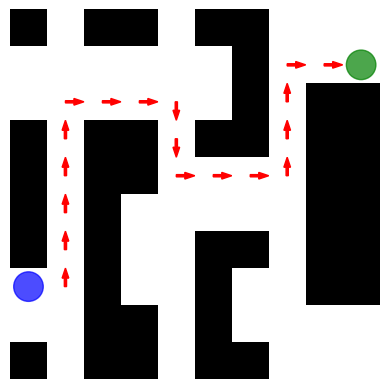

In [10]:
record_trajectory(agent, traj_old_goal)

## New Goal

In [11]:
# Get new maze and initialize a new agent
new_agent = LinearRL(env_name="tolman-10x10-latent-new-goal", _lambda=1.0, alpha=0.01)

In [12]:
# D_inv = new_agent.get_D_inv()
# new_agent.DR = D_inv
# new_agent.update_V()
# new_agent.V.reshape((new_agent.height, new_agent.width))

In [13]:
new_agent.target_loc

array([9, 9])

In [14]:
# New goal location
loc = new_agent.target_loc
idx = agent.mapping[(loc[0], loc[1])]

In [15]:
idx

99

In [16]:
# D0 = agent.DR
# #D_inv = agent.get_D_inv()
# L0 = np.diag(np.exp(-agent.r)) - agent.T
# # D0 = np.linalg.inv(L0)
# L = np.diag(np.exp(-agent.r)) - new_agent.T

In [17]:
# changes = []

# d = L[idx, :] - L0[idx, :]
# m0 = D0[:,idx]

# # Convert d to a row vector of size (1, m)
# d = d.reshape(1, -1)

# # Convert m0 to a column vector of size (m, 1)
# m0 = m0.reshape(-1, 1)

# print(f"d shape: {d.shape}, m0 shape: {m0.shape}")
# print(f"numerator shape: {(np.dot(m0,d)).shape}")
# print(f"denominator shape: {(np.dot(d, m0)).shape}")
# alpha = (np.dot(m0,d)) / (1 + (np.dot(d,m0)))
# print(f"alpha shape: {alpha.shape}")
# change = np.dot(alpha,D0)
# changes.append(change)

# D = np.copy(D0)
# for change in changes:
#     D -= change

In [18]:
L0 = np.diag(np.exp(-agent.r)) - agent.T
L = np.diag(np.exp(-agent.r)) - new_agent.T

# I = np.eye(agent.size)
# D0 = np.linalg.inv(I-agent.gamma*agent.T)
D0 = agent.DR

idx = agent.mapping[(loc[0], loc[1])]

d = L[idx, :] - L0[idx, :]
m0 = D0[:,idx]

# Convert d to a row vector of size (1, m)
d = d.reshape(1, -1)

# Convert m0 to a column vector of size (m, 1)
m0 = m0.reshape(-1, 1)

# Get the amount of change to the DR
alpha = (np.dot(m0,d)) / (1 + (np.dot(d,m0)))
change = np.dot(alpha,D0)

# Apply change to DR
D = np.copy(D0)
D -= change

In [19]:
# D_inv = new_agent.get_D_inv()
# new_agent.DR = D_inv
new_agent.DR = D
new_agent.update_V()
new_agent.V.reshape((agent.height, agent.width))

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_9413/2454964959.py:55: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


array([[  -inf,  -9.42,   -inf,   -inf,  -8.01,   -inf,   -inf,  -7.18,
         -7.88,  -9.52],
       [ -9.5 ,  -9.28,  -8.75,  -8.26,  -7.93,  -7.86,   -inf,  -6.3 ,
         -7.47,   -inf],
       [ -9.53,  -9.25,  -8.6 ,  -8.02,  -7.3 ,  -7.65,   -inf,  -5.43,
          -inf,   -inf],
       [  -inf,  -9.85,   -inf,   -inf,  -6.39,   -inf,   -inf,  -4.77,
          -inf,   -inf],
       [  -inf, -10.34,   -inf,   -inf,  -5.79,  -5.12,  -4.55,  -4.17,
          -inf,   -inf],
       [  -inf, -10.8 ,   -inf,  -6.16,  -5.82,  -5.04,  -4.33,  -3.59,
          -inf,   -inf],
       [  -inf, -11.35,   -inf,  -6.5 ,  -6.34,   -inf,   -inf,  -2.85,
          -inf,   -inf],
       [-12.25, -11.89,   -inf,  -6.7 ,  -6.74,   -inf,  -2.18,  -2.24,
          -inf,   -inf],
       [-12.41, -12.34,   -inf,   -inf,  -7.05,   -inf,  -1.96,  -1.69,
         -1.29,  -1.2 ],
       [  -inf, -12.46,   -inf,   -inf,  -7.18,   -inf,   -inf,  -1.32,
         -0.94,   1.  ]])

In [20]:
new_agent_traj = test_agent(new_agent)

Starting in state: [7 0]
Took action: 1 and arrived in state: [7 1]
Took action: 2 and arrived in state: [6 1]
Took action: 2 and arrived in state: [5 1]
Took action: 2 and arrived in state: [4 1]
Took action: 2 and arrived in state: [3 1]
Took action: 2 and arrived in state: [2 1]
Took action: 1 and arrived in state: [2 2]
Took action: 1 and arrived in state: [2 3]
Took action: 1 and arrived in state: [2 4]
Took action: 0 and arrived in state: [3 4]
Took action: 0 and arrived in state: [4 4]
Took action: 1 and arrived in state: [4 5]
Took action: 1 and arrived in state: [4 6]
Took action: 1 and arrived in state: [4 7]
Took action: 0 and arrived in state: [5 7]
Took action: 0 and arrived in state: [6 7]
Took action: 0 and arrived in state: [7 7]
Took action: 0 and arrived in state: [8 7]
Took action: 1 and arrived in state: [8 8]
Took action: 0 and arrived in state: [9 8]
Took action: 1 and arrived in state: [9 9]
Took 21 steps


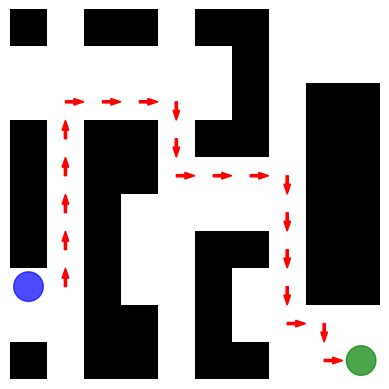

In [21]:
record_trajectory(new_agent, new_agent_traj)